In [1]:
import pandas             as pd
import numpy              as np
import numpy.linalg       as la

import pylab              as pl
from   scipy.spatial      import Delaunay
from   scipy.spatial      import KDTree
from   astropy.table      import Table

from   numba              import jit
import numba              as nb

In [2]:
params = {'legend.fontsize': '20',
          'figure.figsize': (10, 10),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}
pl.rcParams.update(params)

## TCW

In [3]:
data = np.loadtxt("../../data/TracingTheCosmicWeb_PublicData/fof_catalog_200Mpc512.txt", skiprows=3)
N_real = len(data)
pos = data[:N_real,[1,2,3]]
idx = np.arange(0,N_real)

In [4]:
kd_tree_tcw = KDTree(pos)
indexes_tcw = kd_tree_tcw.query_ball_tree(kd_tree_tcw, r=8)
# indexes_tcw = indexes_tcw[:30]

# for i in range(len(indexes_tcw)):
#     for j in indexes_tcw[i]:
#         pl.plot([data[i, 0], data[j, 0]], [data[i, 1], data[j, 1]], "-r")
# pl.show()

In [5]:
kdtree_tcw = np.array([ np.array([np.array(i), len(i)], dtype=object)  for i in indexes_tcw])

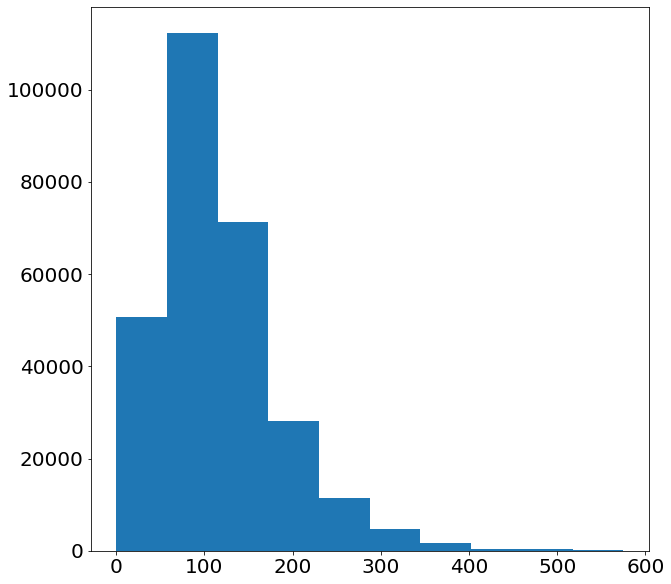

In [6]:
_ = pl.hist(kdtree_tcw[:,1]-1)

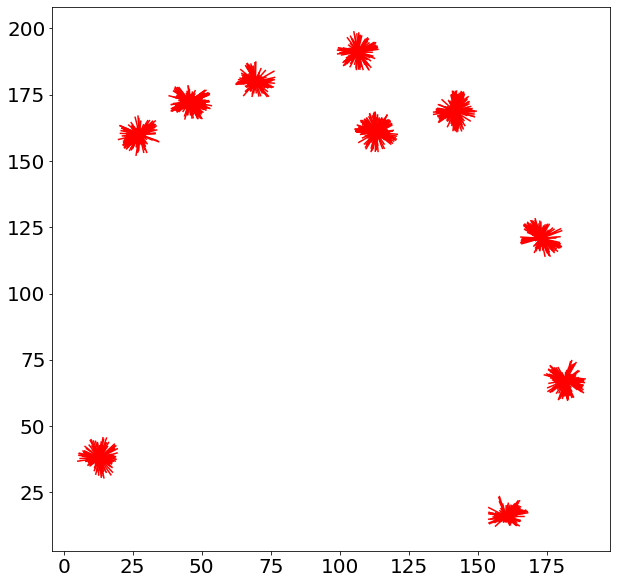

In [7]:
for i in range(len(indexes_tcw[:10])):
    for j in indexes_tcw[i]:
        pl.plot([pos[i,0], pos[j,0]],[pos[i,1], pos[j,1]], "-r")
pl.show()

In [9]:
ngrid = 256
Lbox = 200 #?
print(Lbox)

cellsize = Lbox / ngrid #?
print(cellsize)

volume = Lbox ** 3 #(?)^3
print(volume)

meandensity = len(pos) / volume
print(meandensity)

density, bins = np.histogramdd(pos, bins=ngrid, range=None, normed=None, weights=None, density=None)
print(density.shape)

deltas = (density / meandensity) - 1.
print(np.shape(deltas))

200
0.78125
8000000
0.035183125
(256, 256, 256)
(256, 256, 256)


In [10]:
def Wg(k2, R):
    return np.exp(-k2*R*R/2.)

def get_fourier_smooth(density,R_smooth,N_dim,Lbox):
    karr = np.fft.fftfreq(N_dim, d=Lbox/(2*np.pi*N_dim))
    d_four = np.fft.fftn(density)
    del density
    
    #dksmo = np.zeros(shape=(N_dim, N_dim, N_dim),dtype=complex)
    ksq = np.zeros(shape=(N_dim, N_dim, N_dim),dtype=complex)
    ksq[:,:,:] = karr[None,None,:]**2+karr[None,:,None]**2+karr[:,None,None]**2
    d_four[:,:,:] = Wg(ksq,R_smooth)*d_four

    return karr, ksq, d_four

@jit(nopython=True)
def get_tidal_field(dfour,karr,N_dim):
    tfour = np.zeros(shape=(N_dim, N_dim, N_dim, 3, 3), dtype=nb.complex128)
    
    # computing tidal tensor and phi in fourier space
    # and smoothing using the window functions
    for a in range(N_dim):
        for b in range(N_dim):
            for c in range(N_dim):
                if (a, b, c) == (0, 0, 0):
                    pass
                else:
                    ksq = karr[a]**2 + karr[b]**2 + karr[c]**2
                    # all 9 components
                    tfour[a, b, c, 0, 0] = karr[a]*karr[a]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 1, 1] = karr[b]*karr[b]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 2, 2] = karr[c]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 1, 0] = karr[a]*karr[b]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 0, 1] = tfour[a, b, c, 1, 0]
                    tfour[a, b, c, 2, 0] = karr[a]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 0, 2] = tfour[a, b, c, 2, 0]
                    tfour[a, b, c, 1, 2] = karr[b]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 2, 1] = tfour[a, b, c, 1, 2]

    return tfour

def get_eig(tidt, N_dim):
    evals = np.zeros(shape=(N_dim, N_dim, N_dim, 3))

    for x in range(N_dim):
        for y in range(N_dim):
            for z in range(N_dim):
                # comute and sort evalues in ascending order, for descending add after argsort()[::-1]
                evals[x, y, z, :], evects = la.eig(tidt[x, y, z, :, :])
                idx = evals[x, y, z, :].argsort()
                evals[x, y, z] = evals[x, y, z, idx]
                #evects = evects[:, idx]
    
    lambda1 = evals[:,:,:,0]
    lambda2 = evals[:,:,:,1]
    lambda3 = evals[:,:,:,2]

    return lambda1, lambda2, lambda3

In [11]:
karr, ksd, d_four = get_fourier_smooth(deltas, R_smooth=8., N_dim=ngrid, Lbox=Lbox)

In [12]:
tidal_tilde = get_tidal_field(d_four, karr, ngrid)

In [13]:
tidal_real = np.zeros(shape=(ngrid, ngrid, ngrid, 3, 3),dtype=float) # Normalized by 4. * np.pi * 6.6743e-11

In [14]:
for i in range(3):
    for j in range(3):
        tidal_real[:,:,:,i,j] = np.real(np.fft.ifftn(tidal_tilde[:,:,:,i,j]))

In [15]:
lambda1, lambda2, lambda3 = get_eig(tidal_real, ngrid)

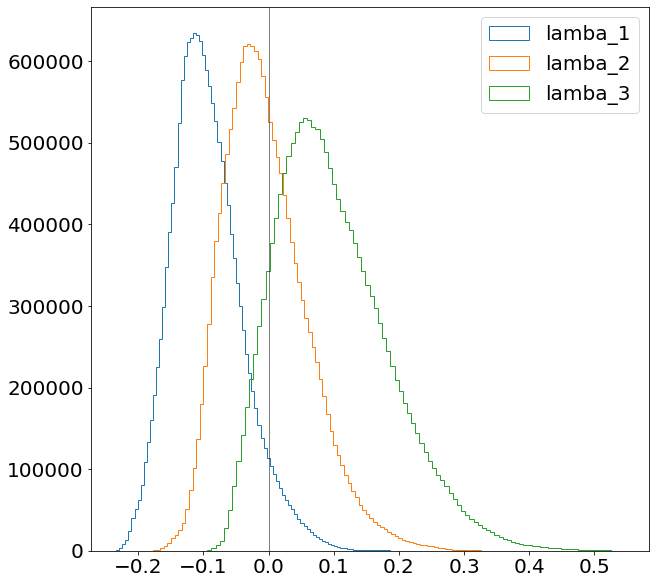

In [16]:
lth = 0.2/200

_ = pl.hist(lambda1.flatten(), histtype='step', bins=100, label='lamba_1')
_ = pl.hist(lambda2.flatten(), histtype='step', bins=100, label='lamba_2')
_ = pl.hist(lambda3.flatten(), histtype='step', bins=100, label='lamba_3')

pl.axvline(lth, c='k', lw=0.5)
pl.legend()

In [17]:
ii_box = (pos[:,0]//cellsize).astype(int)
jj_box = (pos[:,1]//cellsize).astype(int)
kk_box = (pos[:,2]//cellsize).astype(int)

lambda1_halo = lambda1[ii_box, jj_box, kk_box]
lambda2_halo = lambda2[ii_box, jj_box, kk_box]
lambda3_halo = lambda3[ii_box, jj_box, kk_box]
delta_halo = deltas[ii_box, jj_box, kk_box]

In [18]:
environment = np.zeros(len(pos), dtype=int)

# Attached the environment to the galaxies
ii_void = (lambda1_halo < lth) & (lambda2_halo < lth) & (lambda3_halo < lth)
ii_sheet = (lambda3_halo > lth) & (lambda2_halo < lth) & (lambda1_halo < lth)
ii_filament = (lambda3_halo > lth) & (lambda2_halo > lth) & (lambda1_halo < lth)
ii_peak = (lambda1_halo > lth) & (lambda2_halo > lth) & (lambda3_halo > lth)
environment[ii_void] = 3
environment[ii_sheet] = 2        
environment[ii_filament] = 1        
environment[ii_peak] = 0

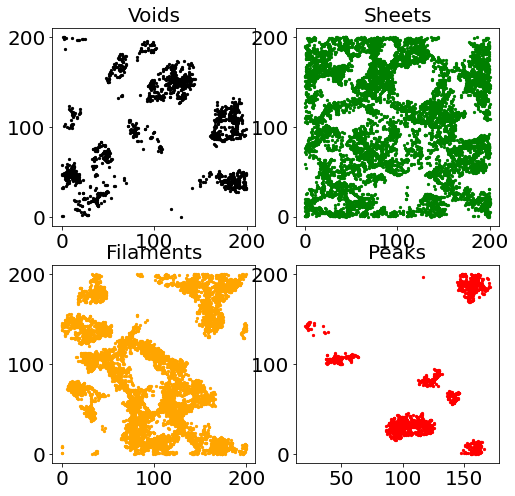

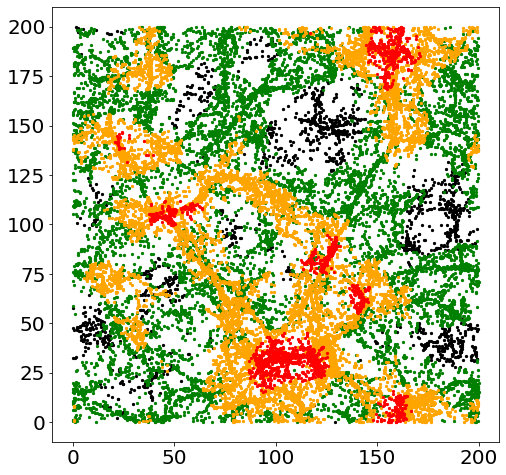

In [19]:
is_slice = (pos[:,2] < 100.)  &   (pos[:,2] > 80.) #Mpc
is_void     = environment == 3
is_sheet    = environment == 2
is_filament = environment == 1
is_peak     = environment == 0

fig = pl.figure(figsize=(8,8))
pl.subplot(2,2,1)
pl.scatter(pos[:,0][is_void & is_slice] , pos[:,1][is_void & is_slice], s=5, c='k')
pl.title('Voids')
pl.subplot(2,2,2)
pl.scatter(pos[:,0][is_sheet & is_slice] , pos[:,1][is_sheet & is_slice], s=5, c='g')
pl.title('Sheets')
pl.subplot(2,2,3)
pl.scatter(pos[:,0][is_filament & is_slice] , pos[:,1][is_filament & is_slice], s=5, c='orange')
pl.title('Filaments')
pl.subplot(2,2,4)
pl.scatter(pos[:,0][is_peak & is_slice] , pos[:,1][is_peak & is_slice], s=5, c='r')
pl.title('Peaks')
pl.show()

fig = pl.figure(figsize=(8,8))
pl.scatter(pos[:,0][is_void & is_slice] , pos[:,1][is_void & is_slice], s=5, c='k')
pl.scatter(pos[:,0][is_sheet & is_slice] , pos[:,1][is_sheet & is_slice], s=5, c='g')
pl.scatter(pos[:,0][is_filament & is_slice] , pos[:,1][is_filament & is_slice], s=5, c='orange')
pl.scatter(pos[:,0][is_peak & is_slice] , pos[:,1][is_peak & is_slice], s=5, c='r')
pl.show()

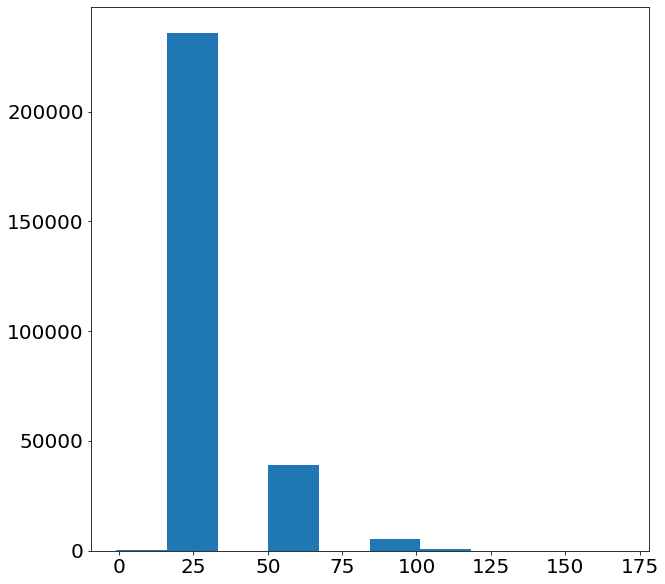

In [20]:
_ = pl.hist(delta_halo)

In [21]:
df = pd.DataFrame(  np.c_[indexes_tcw, lambda1_halo, lambda2_halo, lambda3_halo, environment, delta_halo], columns=['connections','lambda1','lambda2','lambda3','environment', 'odensity']  )
df.to_pickle('./data/TCW_dataset.pkl')

/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/lib/index_tricks.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newobj = array(item, copy=False, subok=True, ndmin=ndmin)


In [22]:
df_temp = pd.read_pickle('./data/TCW_dataset.pkl')

In [23]:
df_temp

,connections,lambda1,lambda2,lambda3,environment,odensity
0,"[0, 2324, 2928, 4068, 4241, 6266, 7123, 7518, ...",0.115914,0.17722,0.417372,0,27.422717
1,"[1, 161, 1054, 1082, 1387, 1541, 1928, 2525, 2...",0.110396,0.366586,0.52877,0,27.422717
2,"[2, 277, 1447, 1676, 3095, 3372, 4635, 4697, 9...",0.016413,0.180315,0.393326,0,27.422717
3,"[3, 71, 890, 1213, 1628, 1755, 3174, 3606, 456...",0.093064,0.284996,0.404295,0,27.422717
4,"[4, 32, 1158, 1308, 2562, 3532, 3894, 4304, 44...",0.195352,0.257187,0.286127,0,27.422717
...,...,...,...,...,...,...
281460,"[476, 686, 1231, 2994, 4319, 5983, 6941, 8413,...",-0.109727,0.071039,0.214417,1,27.422717
281461,"[476, 686, 1231, 2994, 4319, 5983, 6941, 8413,...",-0.108436,0.066158,0.211369,1,27.422717
281462,"[476, 686, 1231, 4319, 5983, 6941, 8413, 9724,...",-0.113513,0.06743,0.205708,1,55.845434
281463,"[476, 6941, 8413, 9724, 13029, 15635, 18410, 1...",-0.120994,0.058269,0.188708,1,27.422717
